In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

2022-01-10 10:35:35.395411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Environment setup

In [3]:
target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']

2022-01-10 10:35:41.291616: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-10 10:35:41.292292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-10 10:35:41.543196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 10:35:41.543492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-10 10:35:41.543507: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-10 10:35:41.547414: I tensorflow/stream_executor/platfo

## Available models

In [4]:
available_models = get_models_by_attack_point(target_config)

Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16
sub_bytes_in    complete                      16
key             complete                      16


## Dataset paths

In [5]:
DATASET_GLOB = "datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 256)
np.load(shard_paths[2])

# Single byte recovery

Let's start by recovering one of the 16 bytes to get a sense of how well the attack work.

**Note**: looking at model accuracy is not enough as we need to invert the attack point AND combine the traces scores. See [presentation](https://elie.net/scaaml) for more information

In [6]:
# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_out'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 7

# load model
model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])

2022-01-10 10:35:41.950200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 10:35:41.951032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 10:35:41.951321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-01-10 10:35:41.951345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic librar

Using our model to predicting bytes attack point value, recovering byte key and combining prediction for the 256 test keys we have in our dataset

In [7]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

    # prediction
    predictions = model.predict(x)
    
    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)
    
    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)
    
    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack
    
    
    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22) 
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

2022-01-10 10:35:50.480061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-10 10:35:50.499135: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3399905000 Hz
2022-01-10 10:35:51.250983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-10 10:35:51.612396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-10 10:35:55.228884: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


## checking model accuracy & confusion matrix
the model accuracy is very good given that the baseline is 1/256 > 0.04. However accuracy is not enough to assess of 
effective the attack is. Instead you need to look at how many traces it takes to recovers 100% of the sub_bytes as visible below.

Looking at the confusion matrix shows that the model perform equaly well on all the predicted value and generalized well: we see a crisp diagonal with no obvious weak points

In [8]:
print("Accuracy: %.2f" % model_metrics['acc'].result())

Accuracy: 0.45


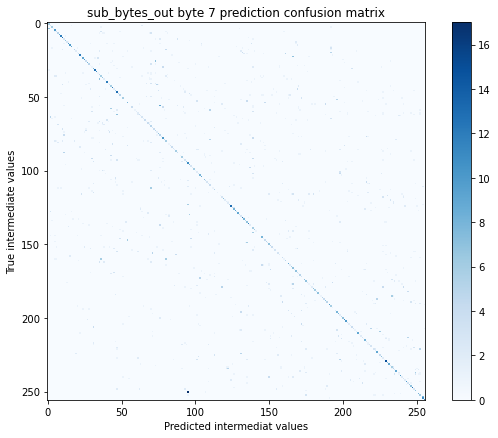

In [9]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))

## byte recovery efficiency


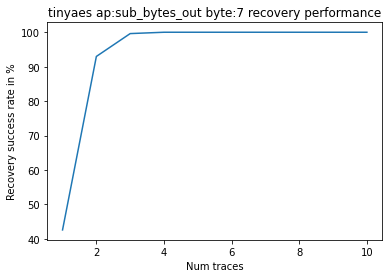

In [10]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100 
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

## metric computations

Let's look at some of the various performances metrics that are used to evaluate attack efficency.
- In the worst case for the implementation the attacker can recover ~40% of the key with a single trace.
- The best case is not really better: 4 traces is all you need.

In [11]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break 

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-'] 
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                1     42.6
max traces                4     100.0
cumulative score         83.79  -


# recover the full keys

In [12]:
ATTACK_POINT = 'sub_bytes_out' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 42 # a shard == a different key. Pick the one you would like
NUM_TRACES = 5  # how many traces to use - as seen in single byte, 5 traces is enough

In [13]:
# perfoming 16x the byte recovery algorithm showecased above - one for each key byte
real_key = [] # what we are supposed to find
recovered_key = [] # what we predicted
pb = tqdm(total=16, desc="guessing key", unit='guesses')
for ATTACK_BYTE in range(16):
    # data
    keys, pts, x, y = load_attack_shard(shard_paths[TARGET_SHARD], ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES, full_key=True)
    real_key.append(keys[0])
    
    # load model
    model = load_model_from_disk(available_models[ATTACK_POINT][ATTACK_BYTE])
    
    # prediction
    predictions = model.predict(x)
    
    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)
    
    # accumulating probabity
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
    
    # order predictions by probability
    guess_ranks = (np.argsort(vals, )[-256:][::-1])
    
    # take strongest guess as our key guess
    recovered_key.append(guess_ranks[0])
    
    # update display
    pb.set_postfix({'Recovered key': bytelist_to_hex(recovered_key), "Real key": bytelist_to_hex(real_key)})
    pb.update()
    
    
pb.close()

guessing key:   0%|          | 0/16 [00:00<?, ?guesses/s]

In [14]:
# check that everything worked out: the recovered key match the real keys
hex_display(real_key, 'real key')
hex_display(recovered_key, 'recovered key')

real key	D5 6F 9E C1 9B B0 5A 11 72 93 E1 B1 16 D5 F3 63
recovered key	D5 6F 9E C1 9B B0 5A 11 72 93 E1 B1 16 D5 F3 63


# Congratulation
you were able to use deep learning to recover an AES key with only a few traces.
For more information check out [papers/tutorials](https://elie.net/scaaml/)